In [131]:
#**** Sentiment Analysis using Dutch Tweets****
# by SELIM SAMETOGLU
# This is a secondary version where I try to implement pipelines from scikitlearn


## Load dependencies

In [132]:
# load the dependencies
# Utility
import pandas as pd
import numpy as np
import re
# Prepro
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# Has to be installed at each runtime
# ! pip install langdetect
# to connect to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [133]:
# Load the dataset
data = pd.read_json("/content/drive/MyDrive/Collab_data/dutch_tweets_chunk0.json")

In [134]:
# Check the lenght of the data
# print('number of messages:', len(data))
# data[["sentiment_pattern"]].hist()
# data[["sentiment_pattern"]]

array([[<Axes: title={'center': 'sentiment_pattern'}>]], dtype=object)

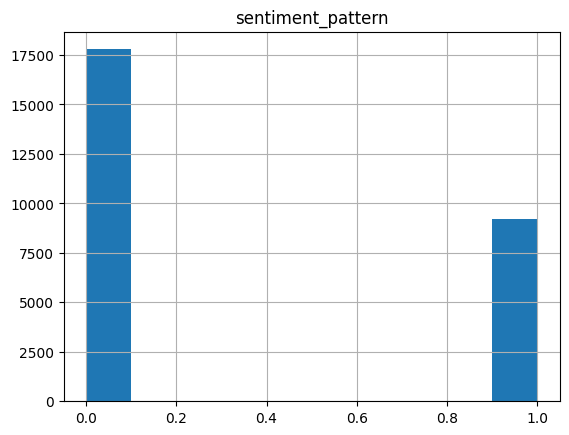

In [135]:
# dichotimize the sentiment categories
data.loc[data["sentiment_pattern"] <0, "sentiment_pattern"] = 0
data.loc[data["sentiment_pattern"] >0, "sentiment_pattern"] = 1
# check with a histogram whether it worked
data[["sentiment_pattern"]].hist()


In [136]:
# take only a small portion of the data for better speed
data = data[:1500]

# Using Custom Transformers and Scikit pipelines for preprocessing

### step 1: Create a custom transformer for filtering out 'Non-Dutch' sentences

In [125]:
#  Creating a preprocessing step with
from sklearn.base import BaseEstimator, TransformerMixin
from langdetect import detect

class LanguageFilter(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

# filter out non-Dutch sentences
  def detect_language(self, X, y=None):
    try:
        return detect(X)
    except:
        return 'unknown'

  def fit(self, X, y = None):
    return self

  def transform(self, X, y= None):
    X['language'] = X['full_text'].apply(self.detect_language)
    X = X[X['language'] == 'nl']
    X.drop('language', axis = 1, inplace = True)
    return X

In [119]:
# call the class
language_filter = LanguageFilter()
# and apply via fit_transform on the data
language_filter.fit_transform(data)

<ipython-input-75-9ec160ddf6c9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('language', axis = 1, inplace = True)


,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,...,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.000000
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.000000
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.372760,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.000000
5,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.372760,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.000000
9,RT @FrankvanWijck: Het aantal deskundigen over...,RT @FrankvanWijck: The number of experts on co...,2020-03-09 12:27:35,martijnmollers,Chirurg @ Heelkunde Friesland | Auteur Hart en...,Surgeon @ Surgery Friesland | Author Heart and...,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,1.0,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,RT @OJongere: 😰😰😰😰🤬🤬🤬🤬🤬\nCorona blijkt stuk ha...,RT @OJongere: 😰😰😰😰🤬🤬🤬🤬🤬\nCorona appears smash ...,2020-04-30 18:14:06,michel180qq,stripboekenverzamelaar sportliefhebber geen r...,comic collector enthusiast disrespect doomsaye...,18,3,30,4,...,None,NaN,NaN,0.0,False,veehouder,61240,True,0.0,0.000000
1494,Waalse PS-minister: “België is een gecomplicee...,"PS Walloon minister: ""Belgium is a complicated...",2020-04-30 18:14:10,BlijfAUBThuis,Opmerkelijke nieuwsflitsen tijdens de Coronavi...,"Notable news flashes during Coronavirus, COVID...",18,3,30,4,...,None,NaN,NaN,NaN,False,"min, minister","7410, 20110",True,0.0,0.900000
1495,Corona in Drenthe en Groningen | De jacht op d...,Corona Drenthe and Groningen | The hunt for th...,2020-04-30 18:14:11,dvhn_nl,Het regionieuws uit Groningen en Drenthe van D...,The region News from Groningen and Drenthe Dag...,18,3,30,4,...,"(53.2190652, 6.5680077, 0.0)",53.219065,6.568008,0.0,Groningen,None,None,False,1.0,0.787500
1496,"RT @Bos_M: Jaap van Dissel, RIVM: 'Ook nieuw o...","RT @Bos_M: Jaap van Dissel, RIVM 'shall also r...",2020-04-30 18:32:04,HoogenKlaas,"No nonsens, vraag niet om een lichte last maar...","No nonsense, do not ask for a light load but a...",18,3,30,4,...,"(52.2391743, 5.3734101, 0.0)",52.239174,5.373410,0.0,Utrecht,None,None,False,1.0,0.216667


1500

In [77]:
# STEP 1: version prior to custom transformers:
# from langdetect import detect
# def detect_language(text):
#    try:
#        return detect(text)
#    except:
#        return 'unknown'
# data['language']=data['full_text'].apply(detect_language)
# data = data[data['language'] == 'nl']
# data.drop('language', axis = 1, inplace = True)

### step 2: column manipulations and turning 'statements into lower case'

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class CoLo(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y= None):
    return self
  def transform(self, X, y=None):
    X = X[["full_text", "sentiment_pattern"]]
    X.columns = ["text", "label"]
    X['text'] = X['text'].str.lower()
    return X


In [79]:
# call the custom transformer and apply it manually (i.e., out of a pipeline to test)
colo = CoLo()
colo.fit_transform(data)

<ipython-input-64-32e97f6df166>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].str.lower()


,text,label
0,"@pflegearzt @friedelkorn @laguja44 pardon, wol...",0.0
1,rt @grantshapps: aviation demand is reduced du...,0.0
2,rt @ddstandaard: de droom van d66 wordt werkel...,0.0
3,rt @ddstandaard: de droom van d66 wordt werkel...,0.0
4,de droom van d66 wordt werkelijkheid: covid-19...,0.0
...,...,...
1495,corona in drenthe en groningen | de jacht op d...,1.0
1496,"rt @bos_m: jaap van dissel, rivm: 'ook nieuw o...",1.0
1497,rt @moorkopje2: @jodelieho wat is dit voor dom...,0.0
1498,rt @moorkopje2: @jodelieho wat is dit voor dom...,0.0


In [9]:
# STEP 2: < old version, pre-pipeline >
# take only the full text and the labels
# data = data[["full_text", "sentiment_pattern"]]

# change the column names
# data.columns = ["text", "label"]

# and check null values, should be 0
# np.sum(data.isnull().any(axis=1))

# also make the statement text in lowercase
# data['text']=data['text'].str.lower()
# data['text'].tail() # check

<ipython-input-9-e3546ea5b6de>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']=data['text'].str.lower()


1495    corona in drenthe en groningen | de jacht op d...
1496    rt @bos_m: jaap van dissel, rivm: 'ook nieuw o...
1497    rt @moorkopje2: @jodelieho wat is dit voor dom...
1498    rt @moorkopje2: @jodelieho wat is dit voor dom...
1499    rt @_sbp99: ik ga niet liegen deze lockdown ha...
Name: text, dtype: object

### step 3: clean and remove the stopwords from the text

In [107]:
    stopwordlist = ['aan','al','alles','als', 'altijd','andere', 'ben','bij',
    'daar','dan','dat','de','der','deze','die','dit','doch','doen','door','dus',
    'een','eens','en','er','ge','geen','geweest','haar','had','heb','hebben','heeft',
    'hem','het','hier','hij','hoe','hun','iemand','iets','ik','in','is','ja',
    'je','kan','kon','kunnen','maar','me','meer','men','met','mij','mijn','moet',
    'na','naar','niet','niets','nog','nu','of','om','omdat','onder','ons','ook',
    'op','reeds','te','tegen','toch','toen','tot','u','uit','uw','van','veel','voor',
    'want','waren','was','wat','werd','wezen','wie','wil','worden','wordt','zal',
    'ze','zelf','zich','zij','zijn','zo','zonder','zou']
    STOPWORDS = set(stopwordlist)

In [138]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanStopwords(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def cleaning_stopwords(self, X, y=None):
    return " ".join([word for word in str(X).split() if word not in STOPWORDS])

  def fit(self, X, y =None):
    return self

  def fit_transform(self, X, y=None):
    X['text'] = X['text'].apply(self.cleaning_stopwords)
    return X


In [139]:
# clean_stopwords = CleanStopwords()

In [144]:
# CREATE A PIPELINE (this only includes 3 preprocessing steps for now, but good for checking right now)
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(LanguageFilter(), CoLo(), CleanStopwords())
pipeline # see it, diagram

Pipeline(steps=[('languagefilter', LanguageFilter()), ('colo', CoLo()),
                ('cleanstopwords', CleanStopwords())])

In [141]:
# execute it
pipeline.fit_transform(data)

<ipython-input-125-9ec160ddf6c9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('language', axis = 1, inplace = True)
<ipython-input-78-32e97f6df166>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].str.lower()


,text,label
2,rt @ddstandaard: droom d66 werkelijkheid: covi...,0.0
3,rt @ddstandaard: droom d66 werkelijkheid: covi...,0.0
4,droom d66 werkelijkheid: covid-19 superdodelij...,0.0
5,droom d66 werkelijkheid: covid-19 superdodelij...,0.0
9,rt @frankvanwijck: aantal deskundigen over cor...,1.0
...,...,...
1493,rt @ojongere: 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk har...,0.0
1494,waalse ps-minister: “belgië gecompliceerd land...,0.0
1495,corona drenthe groningen | jacht mondkapjes ga...,1.0
1496,"rt @bos_m: jaap dissel, rivm: 'ook nieuw onder...",1.0


In [10]:
# STEP 3: clean and remove the stopwords from the text <old version, now integrated as a custom transformer>
# define the DUTCH stopwordlist
# stopwordlist = ['aan','al','alles','als', 'altijd','andere', 'ben','bij','daar','dan','dat','de','der','deze','die','dit','doch','doen','door','dus','een','eens','en','er','ge','geen','geweest','haar','had','heb','hebben','heeft', 'hem','het','hier','hij','hoe','hun','iemand','iets','ik','in','is','ja', 'je','kan','kon','kunnen','maar','me','meer','men','met','mij','mijn','moet', 'na','naar','niet','niets','nog','nu','of','om','omdat','onder','ons','ook', 'op','reeds','te','tegen','toch','toen','tot','u','uit','uw','van','veel','voor', 'want','waren','was','wat','werd','wezen','wie','wil','worden','wordt','zal', 'ze','zelf','zich','zij','zijn','zo','zonder','zou']
# STOPWORDS = set(stopwordlist)
# def cleaning_stopwords(text):
#    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
# data['text'].head() # check

0    @pflegearzt @friedelkorn @laguja44 pardon, wol...
1    rt @grantshapps: aviation demand reduced due t...
2    rt @ddstandaard: droom d66 werkelijkheid: covi...
3    rt @ddstandaard: droom d66 werkelijkheid: covi...
4    droom d66 werkelijkheid: covid-19 superdodelij...
Name: text, dtype: object

In [ ]:
# 30-6-2023; left here, continue with integrating the following preprocessing steps.

In [ ]:
# STEP 4: clean and remove the punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail() # check

1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1498    rt moorkopje2 jodelieho dom antwoord weet wel ...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [11]:
# STEP 5: clean and remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail() # check

1495    corona drenthe groningen | jacht mondkapjes ga...
1496    rt @bos_m: jaap dissel, rivm: 'ook nieuw onder...
1497    rt @moorkopje2: @jodelieho dom antwoord. weet ...
1498    rt @moorkopje2: @jodelieho dom antwoord. weet ...
1499        rt @_sbp99: ga liegen lockdown wel voordelen.
Name: text, dtype: object

In [12]:
# STEP 6: clean and remove URLs
def cleaning_URLs(dataset):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail() #check

1495    corona drenthe groningen | jacht mondkapjes ga...
1496    rt @bos_m: jaap dissel, rivm: 'ook nieuw onder...
1497    rt @moorkopje2: @jodelieho dom antwoord. weet ...
1498    rt @moorkopje2: @jodelieho dom antwoord. weet ...
1499        rt @_sbp99: ga liegen lockdown wel voordelen.
Name: text, dtype: object

In [13]:
# STEP 7: clean and remove numbers
def cleaning_numbers(dataset):
    return re.sub('[0-9]+', '', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail() #check

1495    corona drenthe groningen | jacht mondkapjes ga...
1496    rt @bos_m: jaap dissel, rivm: 'ook nieuw onder...
1497    rt @moorkopje: @jodelieho dom antwoord. weet w...
1498    rt @moorkopje: @jodelieho dom antwoord. weet w...
1499          rt @_sbp: ga liegen lockdown wel voordelen.
Name: text, dtype: object

In [14]:
# STEP 8: tokenization
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

0       [@, pflegearzt, @, friedelkorn, @, laguja, par...
1       [rt, @, grantshapps, :, aviation, demand, redu...
2       [rt, @, ddstandaard, :, droom, d, werkelijkhei...
3       [rt, @, ddstandaard, :, droom, d, werkelijkhei...
4       [droom, d, werkelijkheid, :, covid, superdodel...
                              ...                        
1495    [corona, drenthe, groningen, |, jacht, mondkap...
1496    [rt, @, bos_m, :, jaap, dissel, ,, rivm, :, 'o...
1497    [rt, @, moorkopje, :, @, jodelieho, dom, antwo...
1498    [rt, @, moorkopje, :, @, jodelieho, dom, antwo...
1499    [rt, @, _sbp, :, ga, liegen, lockdown, wel, vo...
Name: text, Length: 1500, dtype: object

In [15]:
# STEP 9: stemming
from nltk.stem.snowball import DutchStemmer

st = DutchStemmer()
def stemming_on_text(dataset):
    text = [st.stem(word) for word in dataset]
    return dataset
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

0    [@, pflegearzt, @, friedelkorn, @, laguja, par...
1    [rt, @, grantshapps, :, aviation, demand, redu...
2    [rt, @, ddstandaard, :, droom, d, werkelijkhei...
3    [rt, @, ddstandaard, :, droom, d, werkelijkhei...
4    [droom, d, werkelijkheid, :, covid, superdodel...
Name: text, dtype: object

In [16]:
# create the 'X' with the features, and create the'y' with the annotations/sentiment
X = data['text']
y = data['label']


## WordClouds

In [17]:
# Categorize data as positive and negative
data_pos = data.loc[data['label'] == 1]
data_neg = data.loc[data['label'] == 0]
data_pos = data_pos['text']
data_neg = data_neg['text']

### Word cloud for negative words

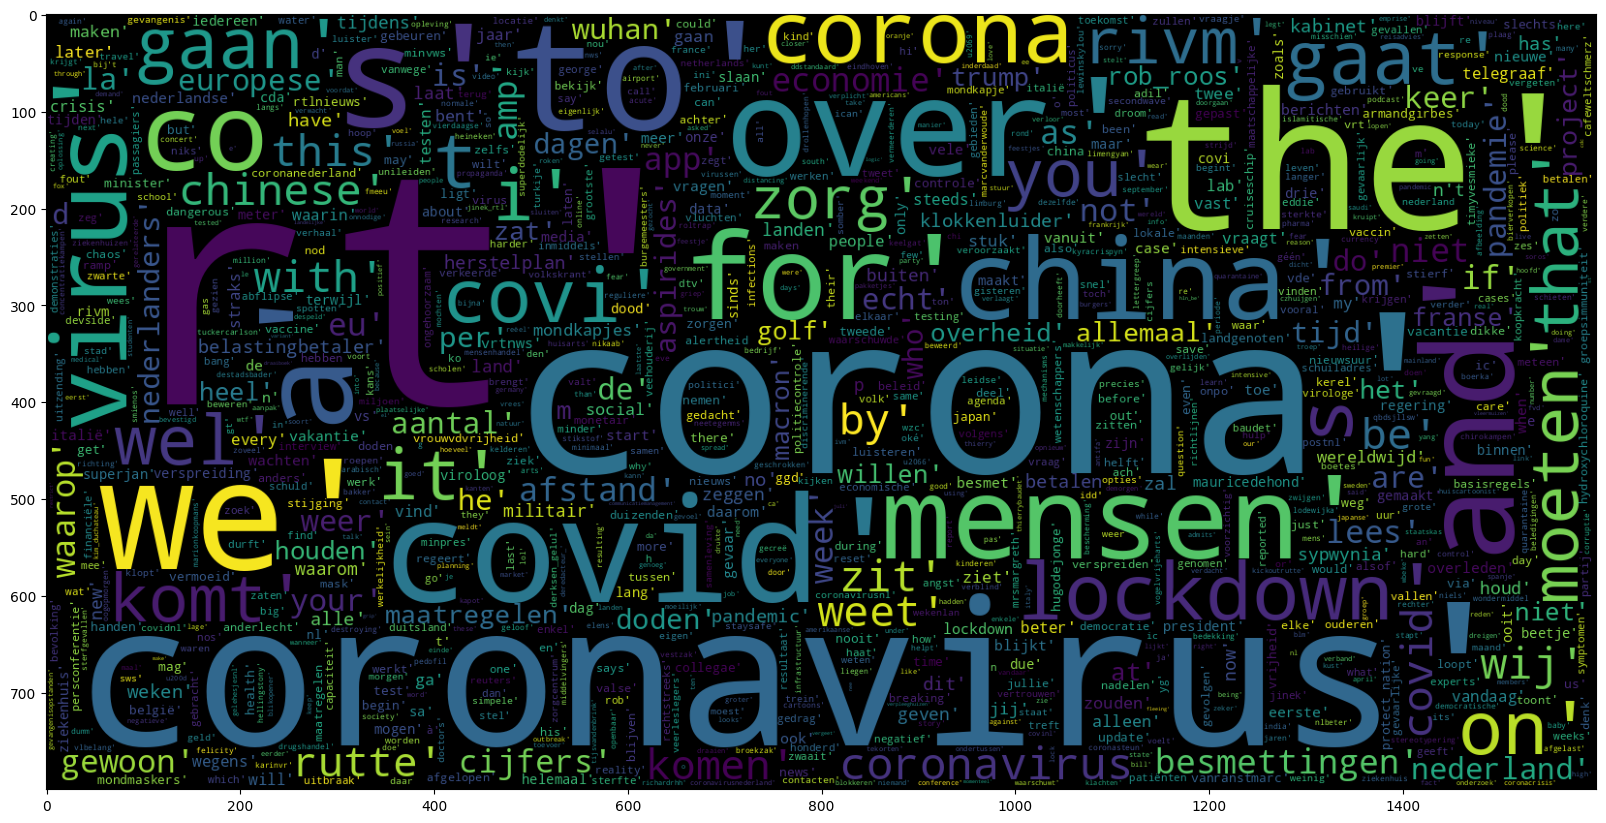

In [18]:
# Neg word cloud
# data_neg = data_neg[:9230]
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg)))
plt.imshow(wc_neg)


### Word cloud for positive words

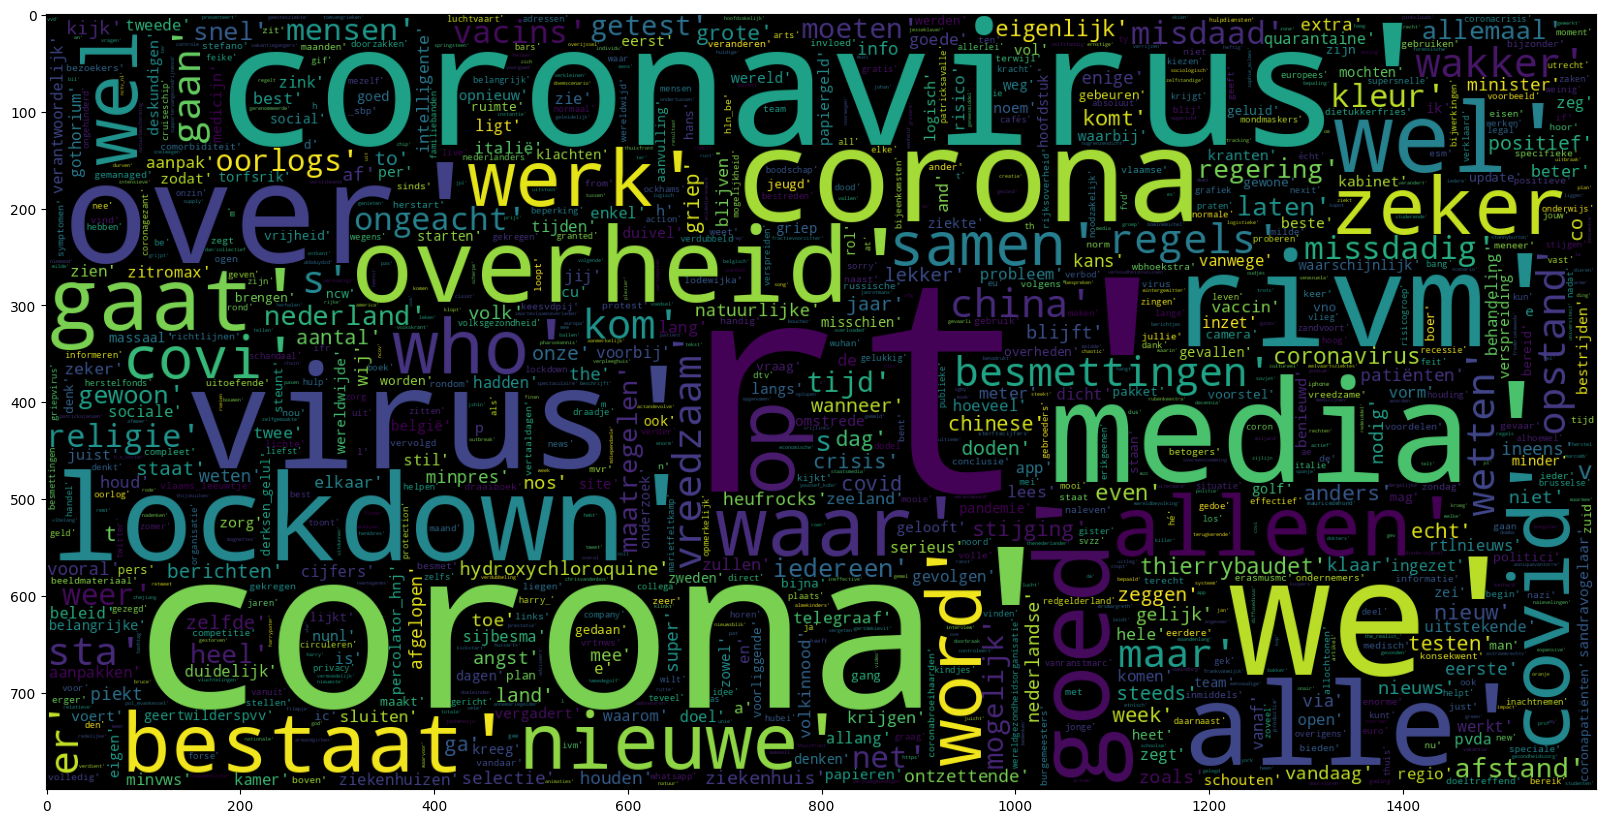

In [19]:
# pos wordcloud
# data_pos = data_pos[:17789]
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_pos)))
plt.imshow(wc_pos)


## Modelling

## Prepare the data

In [20]:
# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [21]:
# Turn data into strings (ensures, otherwise may throw an error)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

### Fit the TF-IDF Vectorizer

In [22]:
# Fit the tf-idf vectorizer on the training data (!)
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [23]:
# Check how many feature words are extracted
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  18081


### Transform the data according to TF-IDF vectorizer

In [24]:
# Transform the data (both train and test data!) using the tf-idf vectorizer
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

### Model Evaluation

In [25]:
# Define a function for model evaluation
# creds to https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model 1: Train and evaluate a Bernoulli Naive Bayes model

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        54
         1.0       1.00      0.29      0.44        21

    accuracy                           0.80        75
   macro avg       0.89      0.64      0.66        75
weighted avg       0.84      0.80      0.76        75



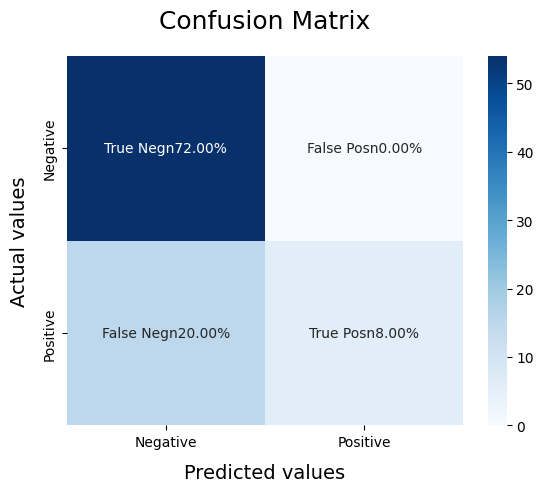

In [26]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

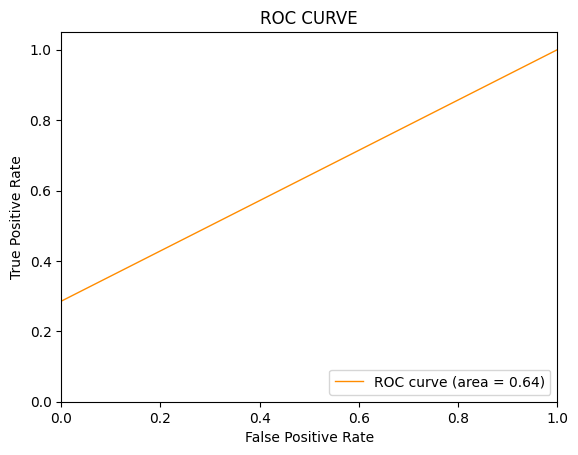

In [27]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 2: Train and evaluate a Linear Support Vector Classification model

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94        54
         1.0       0.94      0.71      0.81        21

    accuracy                           0.91        75
   macro avg       0.92      0.85      0.87        75
weighted avg       0.91      0.91      0.90        75



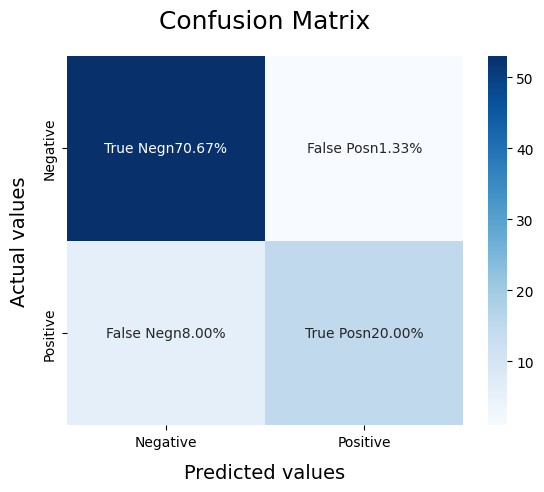

In [28]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

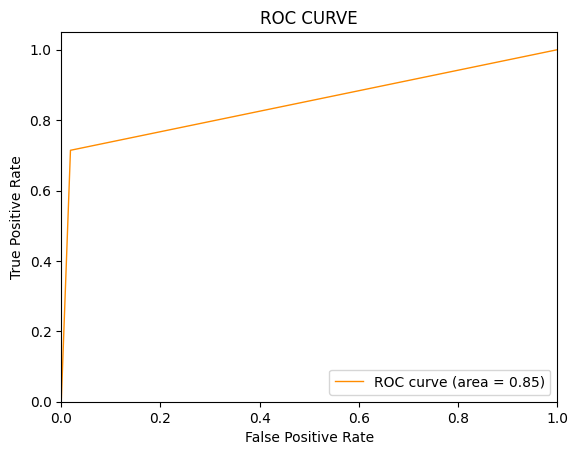

In [29]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 3: Train and evaluate a Logistic regression model

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91        54
         1.0       0.92      0.57      0.71        21

    accuracy                           0.87        75
   macro avg       0.89      0.78      0.81        75
weighted avg       0.87      0.87      0.86        75



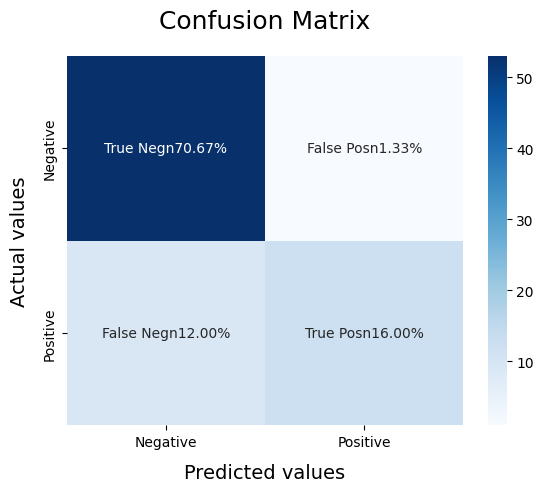

In [30]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

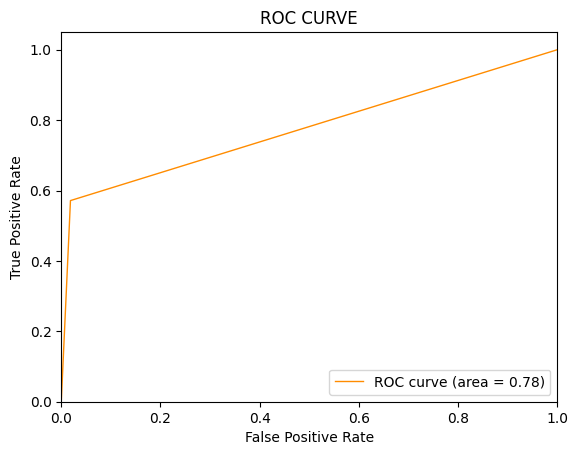

In [31]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Overall Interpretation:

In [ ]:
# The linear support vector classifier (svc) worked the best